#### Получить данные с сайта МСВЗ ([http](https://www.iers.org)) можно несколькими способами, как пример я приведу два:  
- Вручную. Зайти на сайт, открыть вкладку Data/Products/Tools и выбрать Earth orientation data.  
- Выгрузить файл с помощью запроса. В ячейке ниже я приведу код для скачивания.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
from astropy.time import Time
import math

In [2]:
# Ссылку можно получить, скопировав гиперссылку на сайте
data_url = "https://datacenter.iers.org/data/csv/eopc04_14_IAU2000.62-now.csv"

r = requests.get(data_url)

if r.status_code != 200:
    print('Не удалось скачать файл')
else:
    open('data.csv', "wb").write(r.content)


In [7]:
iers_df = pd.read_csv('data.csv', sep=';')
iers_df.head()

,MJD,Year,Month,Day,Type,x_pole,sigma_x_pole,y_pole,sigma_y_pole,x_rate,...,sigma_LOD,Type.2,dPsi,sigma_dPsi,dEpsilon,sigma_dEpsilon,dX,sigma_dX,dY,sigma_dY
0,37665,1962,1,1,NaN,-0.012700,0.03,0.213000,0.03,NaN,...,0.0014,NaN,NaN,NaN,NaN,NaN,0.0,0.004774,0.0,0.002
1,37666,1962,1,2,NaN,-0.015900,0.03,0.214100,0.03,NaN,...,0.0014,NaN,NaN,NaN,NaN,NaN,0.0,0.004774,0.0,0.002
2,37667,1962,1,3,NaN,-0.019000,0.03,0.215200,0.03,NaN,...,0.0014,NaN,NaN,NaN,NaN,NaN,0.0,0.004774,0.0,0.002
3,37668,1962,1,4,NaN,-0.021999,0.03,0.216301,0.03,NaN,...,0.0014,NaN,NaN,NaN,NaN,NaN,0.0,0.004774,0.0,0.002
4,37669,1962,1,5,NaN,-0.024799,0.03,0.217301,0.03,NaN,...,0.0014,NaN,NaN,NaN,NaN,NaN,0.0,0.004774,0.0,0.002


In [8]:
needed_cols_list = ['MJD', 'x_pole', 'y_pole', 'UT1-UTC']
iers_df.head()[needed_cols_list]

,MJD,x_pole,y_pole,UT1-UTC
0,37665,-0.012700,0.213000,0.032634
1,37666,-0.015900,0.214100,0.032055
2,37667,-0.019000,0.215200,0.031553
3,37668,-0.021999,0.216301,0.031144
4,37669,-0.024799,0.217301,0.030815


<Axes: title={'center': 'UT1-UTC'}>

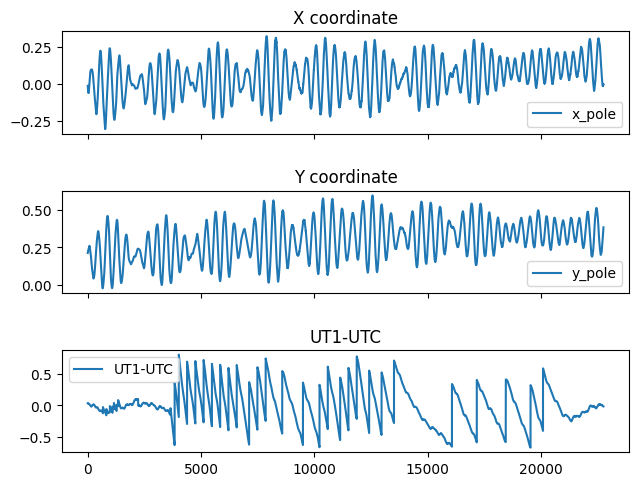

In [14]:
fig, axes = plt.subplots(3, 1)
fig.tight_layout(h_pad= 2 )

iers_df.plot(y='x_pole', title='X coordinate', sharex=True, ax=axes[0])
iers_df.plot(y='y_pole', title='Y coordinate', sharex=True, ax=axes[1])
iers_df.plot(y='UT1-UTC', title='UT1-UTC', sharex=True, ax=axes[2])


##### Видно, что временные ряды X и Y имеют гармонический характер (модель строить можно), а у ряда UT1-UTC имеются скачки. Каждый такой скачок является добавочной секундой. МСВЗ каждые полгода публикует [Бюллетень С](https://www.iers.org/IERS/EN/DataProducts/EarthOrientationData/eop.html), в которой сообщает актуальное значение секунды скачка, сейчас это 37 секунд. Очевидно, что строить модель UT1-UTC с такими данными неадекватно. Поэтому необходимо провести процедуру обработки данных (удалить секунды скачка и приливные воздействия).

В следующей ячейке будут приведены функции позволяющие подготовить данные UT1-UTC к прогнозу.

In [21]:
def remove_leap_seconds(data: np.ndarray, leap_sec: int) -> (np.ndarray, np.ndarray):
    a = data.flatten()[::-1]
    removed_secs = np.zeros(len(data.flatten()))
    prev = 0
    for i in range(len(data.flatten()) - 1):
        if a[i] - a[i + 1] > 0.9:
            a[prev:i+1] -= leap_sec
            removed_secs[prev:i+1] += leap_sec
            prev = i + 1
            leap_sec -= 1
    a[prev:] -= leap_sec
    return a[::-1], removed_secs[::-1]


def prepare_d_ut_sample_iers(data: np.ndarray, mjds: np.ndarray, mode: bool, harmonics_n: int) -> tuple[np.ndarray, np.ndarray]:
    tidal = pd.read_csv('tidal.csv')
    n = len(data)
    removal = np.zeros(n)
    for i in range(n):
        alpha = evaluate_tidal_params_of_d_ut(mjds[i])
        for j in range(harmonics_n):
            argument = (tidal['l'][j] * alpha[0] + tidal['l_marked'][j] * alpha[1] + tidal['F'][j] * alpha[2] +
                        tidal['D'][j] * alpha[3] + tidal['Omega'][j] * alpha[4]) / 180 * math.pi
            removal[i] += tidal['B'][j] * 10 ** (-4) * math.sin(argument) + tidal['C'][j] * 10 ** (-4) * math.cos(argument)

    data = data - removal if mode else data + removal

    return data, removal


def evaluate_tidal_params_of_d_ut(mjd: int) -> list[float]:
    t = (Time(mjd, format='mjd').jd1 - 2451545.0) / 36525
    l = 134.96340251 + (1717915923.2178 * t + 31.8792 * t ** 2 + 0.051635 * t ** 3 - 0.00024470 * t ** 4) / 3600
    l_marked = 357.52910918 + (
                129596581.0481 * t - 0.5532 * t ** 2 + 0.000136 * t ** 3 - 0.00001149 * t ** 4) / 3600
    f = 93.27209062 + (1739527262.8478 * t - 12.7512 * t ** 2 - 0.001037 * t ** 3 - 0.00000417 * t ** 4) / 3600
    d = 297.85019547 + (1602961601.2090 * t - 6.3706 * t ** 2 + 0.006593 * t ** 3 - 0.00003169 * t ** 4) / 3600
    omega = 125.04455501 + (-6962890.5431 * t + 7.4722 * t ** 2 + 0.007702 * t ** 3 - 0.00005939 * t ** 4) / 3600
    return [l, l_marked, f, d, omega]

In [25]:
iers_df['UT1-UTC'].to_numpy()

array([ 0.0326338,  0.0320547,  0.0315526, ..., -0.0167723, -0.0170611,
       -0.0174909])

In [26]:
dut_without_leap_secs, _ = remove_leap_seconds(iers_df['UT1-UTC'].to_numpy(), 37)



In [27]:
dut_data, removed_tidals = prepare_d_ut_sample_iers(dut_without_leap_secs, iers_df['MJD'].to_numpy(), True, 62)

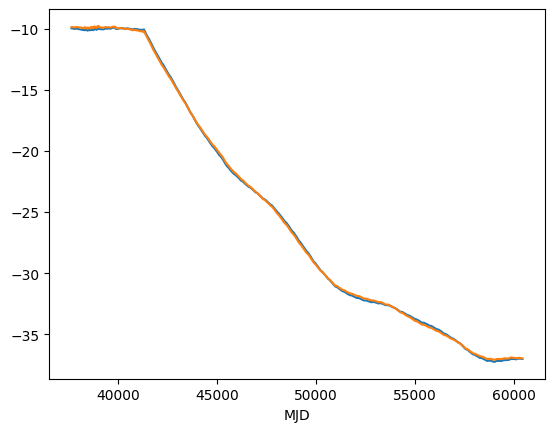

In [29]:
plt.figure()
plt.plot(iers_df['MJD'].to_numpy(), dut_without_leap_secs, label='UT1-UTC w/o leap seconds')
plt.plot(iers_df['MJD'].to_numpy(), dut_data, label='Prepared UT1-UTC')

plt.xlabel('MJD')
plt.show()

По временному ряду такого вида уже можно строить прогнозы.